In [4]:
#import necessary libraries.
import pandas as pd
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# get dataset. 2019-2024 dataset from football-data.co.uk
file = 'historical_data.csv'
matches = pd.read_csv(file, usecols=range(1,11))

In [6]:
matches.head()

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4,0,H
1,10/08/2019,12:30,West Ham,Man City,0,5,A,0,1,A
2,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0,0,D
3,10/08/2019,15:00,Burnley,Southampton,3,0,H,0,0,D
4,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0,0,D


In [7]:
matches.tail()

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
1818,03/04/2024,19:30,Arsenal,Luton,2,0,H,2,0,H
1819,03/04/2024,19:30,Brentford,Brighton,0,0,D,0,0,D
1820,03/04/2024,20:15,Man City,Aston Villa,4,1,H,2,1,H
1821,04/04/2024,19:30,Liverpool,Sheffield United,3,1,H,1,0,H
1822,04/04/2024,20:15,Chelsea,Man United,4,3,H,2,2,D


In [8]:
# Convert 'Date' column to datetime format
matches['Date'] = pd.to_datetime(matches['Date'], format='%d/%m/%Y')

In [9]:
# aggregate by home away team and return avg home away goals
result = matches.groupby(['HomeTeam', 'AwayTeam']).agg({
    'FTHG': 'mean',
    'FTAG': 'mean'
})
print(result)

                          FTHG  FTAG
HomeTeam AwayTeam                   
Arsenal  Aston Villa  2.000000  1.75
         Bournemouth  2.000000  1.00
         Brentford    1.666667  1.00
         Brighton     1.200000  1.40
         Burnley      1.250000  0.75
...                        ...   ...
Wolves   Southampton  1.500000  0.75
         Tottenham    1.000000  1.00
         Watford      3.000000  0.00
         West Brom    2.000000  3.00
         West Ham     1.500000  0.75

[610 rows x 2 columns]


In [12]:
# Head to head between every team pairing in the last 5 seasons
h2h = matches.groupby(['HomeTeam', 'AwayTeam']).agg({
    'FTHG': 'mean',
    'FTAG': 'mean'
})

# Get the specific group for Arsenal vs Chelsea
h2htable = matches.groupby(['HomeTeam', 'AwayTeam']).get_group(('Arsenal', 'Chelsea'))

h2htable.head()

,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
196,2019-12-29,14:00,Arsenal,Chelsea,1,2,A,1,0,H
520,2020-12-26,17:30,Arsenal,Chelsea,3,1,H,2,0,H
778,2021-08-22,16:30,Arsenal,Chelsea,0,2,A,0,2,A
1473,2023-05-02,20:00,Arsenal,Chelsea,3,1,H,3,0,H


In [36]:
# set parameters, home team, away team, and n no of trials.
home = 'Arsenal'
away = 'Aston Villa'
trials = 100000

# Function to simulate the match score
def get_score(home, away):
    home_mean = h2h.loc[(home, away), 'FTHG']  # home team goals
    away_mean = h2h.loc[(home, away), 'FTAG']  # away team goals

    # Simulate score by random sampling from parametrised Poisson distribution. home_mean, away_mean as the λ parameter for the Poisson distribution.
    home_score = poisson.rvs(home_mean, size=1)[0]
    away_score = poisson.rvs(away_mean, size=1)[0]

    return (home_score, away_score)


get_score(home, away)

#get_score uses historical average goals data and the Poisson distribution to simulate a realistic scoreline for a match between a specified home and away team. 

(1, 1)

In [37]:
# collect results for n no of trials.
results = [get_score(home, away) for _ in range(trials)]


In [38]:
# Extracting all home and away scores separately
home_scores = [result[0] for result in results]
away_scores = [result[1] for result in results]

In [39]:
# helper function returns match result (home win, away win, draw)
def get_result(home_score, away_score):
    if home_score > away_score:
        result = 'H'
    elif home_score < away_score:
        result = 'A'
    else:
        result = 'D'
    return result

get_result(1,1)  #test function 1-1 = draw

'D'

In [40]:
def get_scores(home, away):
    # Check if head-to-head results exist
    try:
        # Retrieve head-to-head results in the last 5 seasons
        home_mean = h2h.loc[(home, away)]['FTHG']
        away_mean = h2h.loc[(home, away)]['FTAG']
        print(f"Using head-to-head data: {home} vs {away} with means {home_mean} and {away_mean}.")
    except KeyError:
        # If head-to-head results are unavailable, use last 5 seasons home and away form
        home_scored = home_form.loc[home, 'FTHG']
        home_conceded = home_form.loc[home, 'FTAG']
        away_scored = away_form.loc[away, 'FTAG']
        away_conceded = away_form.loc[away, 'FTHG']

        # Calculate averages over goals for and against each team
        home_mean = (home_scored + away_conceded) / 2
        away_mean = (away_scored + home_conceded) / 2
        print(f"No head-to-head data found. Using last season's forms for {home} and {away}.")
        print(f"Calculated means are {home_mean} for {home} and {away_mean} for {away}.")

    # Simulate scores by random sampling from parametrized Poisson distribution
    home_scores = poisson.rvs(home_mean, size=trials, random_state=2)
    away_scores = poisson.rvs(away_mean, size=trials, random_state=0)
    
    # Combine scores into DataFrame and calculate the most common result
    scores = pd.DataFrame(data={'home': home_scores, 'away': away_scores})
    scores['result'] = scores['home'].astype(str) + '-' + scores['away'].astype(str)
    score_predictions = scores['result'].value_counts()
    score_probability = round(score_predictions / trials * 100, 1)

    # Determine match outcome and calculate probabilities
    scores['outcome'] = scores.apply(lambda x: get_result(int(x['home']), int(x['away'])), axis=1)
    outcome_predictions = scores['outcome'].value_counts()
    outcome_probability = round(outcome_predictions / trials * 100, 1)

    # Print the most probable scoreline and outcome with associated probabilities
    most_probable_scoreline = score_predictions.index[0]
    most_probable_scoreline_probability = score_probability[0]
    most_probable_outcome = outcome_predictions.index[0]
    most_probable_outcome_probability = outcome_probability[0]

    print(f"The most probable scoreline is {most_probable_scoreline} with a probability of {most_probable_scoreline_probability}%.")
    print(f"The most probable outcome is {most_probable_outcome} ('H' for Home win, 'A' for Away win, 'D' for Draw) with a probability of {most_probable_outcome_probability}%.")

    return most_probable_scoreline, most_probable_scoreline_probability, most_probable_outcome, most_probable_outcome_probability, outcome_predictions

# When calling the function, capture the returned outcome_predictions
most_probable_scoreline, most_probable_scoreline_probability, most_probable_outcome, most_probable_outcome_probability, outcome_predictions = get_scores(home, away)


Using head-to-head data: Arsenal vs Aston Villa with means 2.0 and 1.75.
The most probable scoreline is 1-1 with a probability of 8.3%.
The most probable outcome is H ('H' for Home win, 'A' for Away win, 'D' for Draw) with a probability of 44.2%.


C:\Users\AmarL\AppData\Local\Temp\ipykernel_16368\2679521577.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  most_probable_scoreline_probability = score_probability[0]
C:\Users\AmarL\AppData\Local\Temp\ipykernel_16368\2679521577.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  most_probable_outcome_probability = outcome_probability[0]


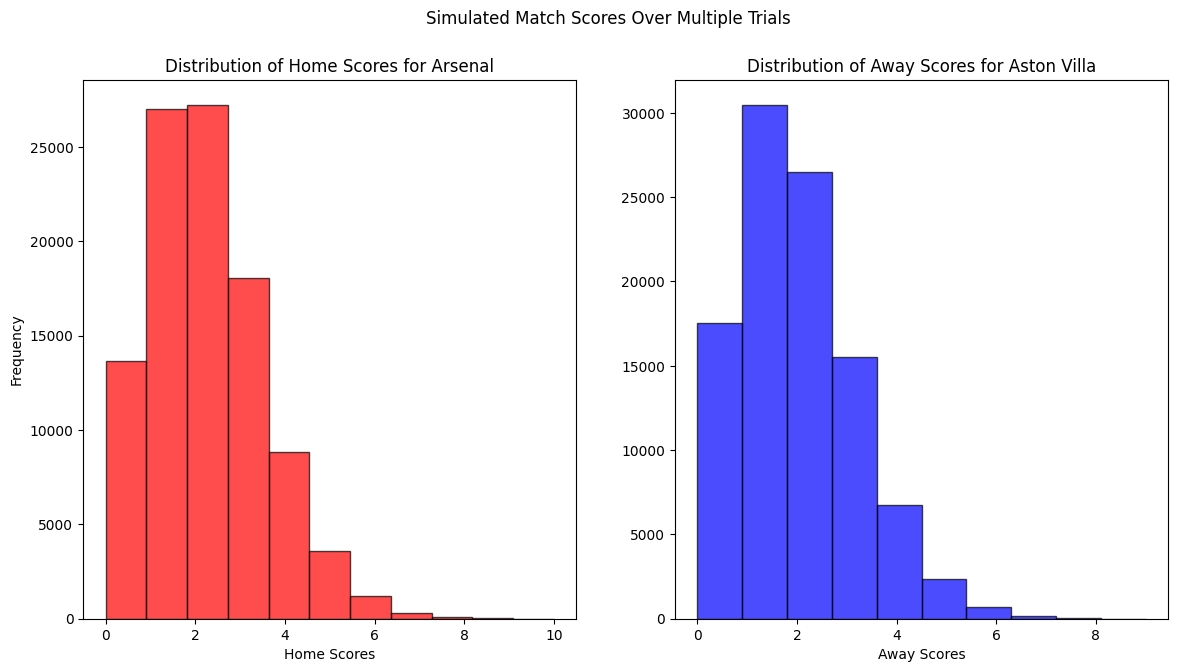

In [41]:
# Plotting the histogram
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # Home scores histogram
plt.hist(home_scores, bins=max(home_scores)+1, alpha=0.7, color='red', edgecolor='black')
plt.title(f'Distribution of Home Scores for {home}')
plt.xlabel('Home Scores')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # Away scores histogram
plt.hist(away_scores, bins=max(away_scores)+1, alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Distribution of Away Scores for {away}')
plt.xlabel('Away Scores')

plt.suptitle('Simulated Match Scores Over Multiple Trials')
plt.show()

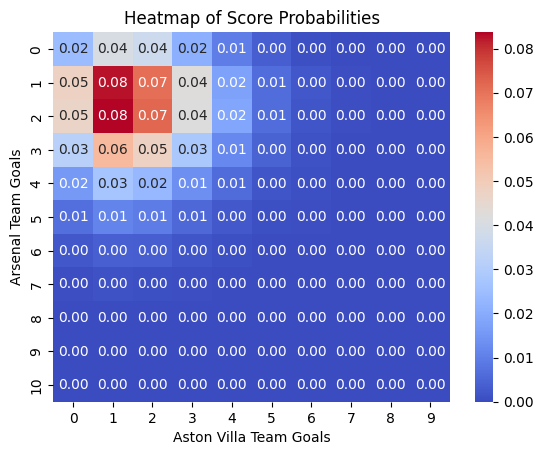

In [42]:
# results dataframe
results = pd.DataFrame({'home': home_scores, 'away': away_scores})
result_count = results.groupby(['home', 'away']).size().unstack(fill_value=0)

# Normalise to get probabilities
result_probabilities = result_count / result_count.sum().sum()

sns.heatmap(result_probabilities, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Score Probabilities')
plt.xlabel(f'{away} Team Goals')
plt.ylabel(f'{home} Team Goals')
plt.show()

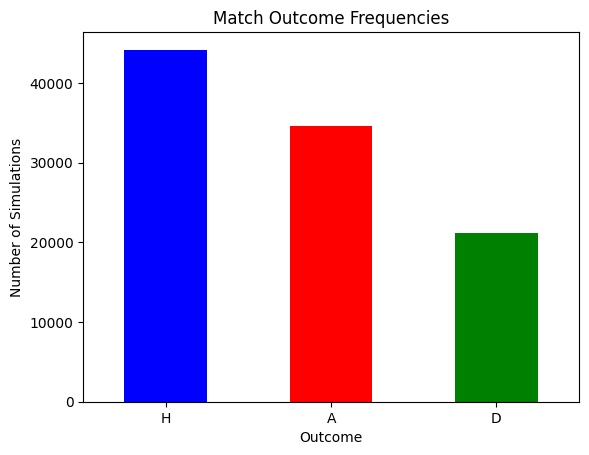

In [43]:
# Assuming `outcome_predictions` is already calculated from your function
outcome_predictions.plot(kind='bar', color=['blue', 'red', 'green'])
plt.title('Match Outcome Frequencies')
plt.xlabel('Outcome')
plt.ylabel('Number of Simulations')
plt.xticks(rotation=0)
plt.show()

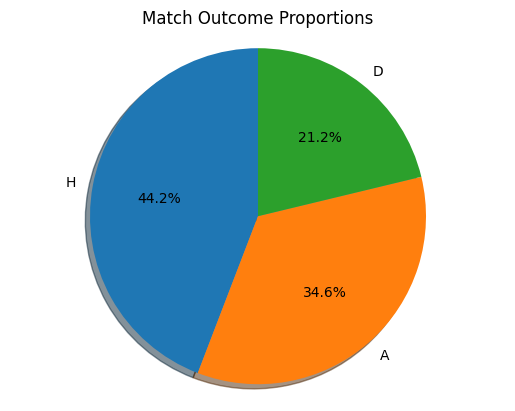

In [44]:
fig, ax = plt.subplots()
ax.pie(outcome_predictions, labels=outcome_predictions.index, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Match Outcome Proportions')
plt.show()